Processing dataset for 7-day prediction
Features being dropped: []
Loading data...
Test set contains 7 unique dates.
Creating spatial features...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing chunks: 100%|██████████| 488/488 [02:13<00:00,  3.66it/s]


Creating spatial features...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing chunks: 100%|██████████| 24/24 [00:04<00:00,  5.06it/s]


Using device: cuda


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]

Day: 2024-02-09, Epoch: 1/3, Loss: 0.010314
Day: 2024-02-09, Epoch: 2/3, Loss: 0.004339


Processing days:  14%|█▍        | 1/7 [01:19<07:59, 79.92s/it]

Day: 2024-02-09, Epoch: 3/3, Loss: 0.003878
Day: 2024-02-10, Epoch: 1/3, Loss: 0.004155
Day: 2024-02-10, Epoch: 2/3, Loss: 0.003700


Processing days:  29%|██▊       | 2/7 [02:41<06:44, 80.89s/it]

Day: 2024-02-10, Epoch: 3/3, Loss: 0.003507
Day: 2024-02-11, Epoch: 1/3, Loss: 0.003599
Day: 2024-02-11, Epoch: 2/3, Loss: 0.003238


Processing days:  43%|████▎     | 3/7 [04:07<05:32, 83.11s/it]

Day: 2024-02-11, Epoch: 3/3, Loss: 0.003176
Day: 2024-02-12, Epoch: 1/3, Loss: 0.003005
Day: 2024-02-12, Epoch: 2/3, Loss: 0.003009


Processing days:  57%|█████▋    | 4/7 [05:23<04:01, 80.59s/it]

Day: 2024-02-12, Epoch: 3/3, Loss: 0.002830
Day: 2024-02-13, Epoch: 1/3, Loss: 0.002894
Day: 2024-02-13, Epoch: 2/3, Loss: 0.002800


Processing days:  71%|███████▏  | 5/7 [06:40<02:38, 79.26s/it]

Day: 2024-02-13, Epoch: 3/3, Loss: 0.002785
Day: 2024-02-14, Epoch: 1/3, Loss: 0.002766
Day: 2024-02-14, Epoch: 2/3, Loss: 0.002723


Processing days:  86%|████████▌ | 6/7 [08:05<01:20, 80.98s/it]

Day: 2024-02-14, Epoch: 3/3, Loss: 0.002748
Day: 2024-02-15, Epoch: 1/3, Loss: 0.002739
Day: 2024-02-15, Epoch: 2/3, Loss: 0.002728


Processing days: 100%|██████████| 7/7 [09:32<00:00, 81.80s/it]

Day: 2024-02-15, Epoch: 3/3, Loss: 0.002650

===== ST-RAP MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1811
MAE: 0.0954
R²: 0.9667
MAPE: 93.3285%

=== Daily Performance ===
      date     rmse      mae       mape  n_samples
2024-02-09 0.345676 0.200683 183.680711       3331
2024-02-10 0.237035 0.137972 131.055911       3331
2024-02-11 0.110149 0.081349 109.346376       3331
2024-02-12 0.139889 0.121276 117.019215       3331
2024-02-13 0.100537 0.066926  66.327462       3331
2024-02-14 0.069303 0.036422  27.781634       3331
2024-02-15 0.085346 0.023424  18.088083       3331

=== Performance Statistics ===
MAE:
  Average: 0.0954
  Min: 0.0234 (Day: 2024-02-15 00:00:00)
  Max: 0.2007 (Day: 2024-02-09 00:00:00)

RMSE:
  Average: 0.1554
  Min: 0.0693 (Day: 2024-02-14 00:00:00)
  Max: 0.3457 (Day: 2024-02-09 00:00:00)

MAPE:
  Average: 93.33%
  Min: 18.09% (Day: 2024-02-15 00:00:00)
  Max: 183.68% (Day: 2024-02-09 00:00:00)

=== Error Autocorrelation ===
  Lag 1: 0.0601
  Lag 2: 

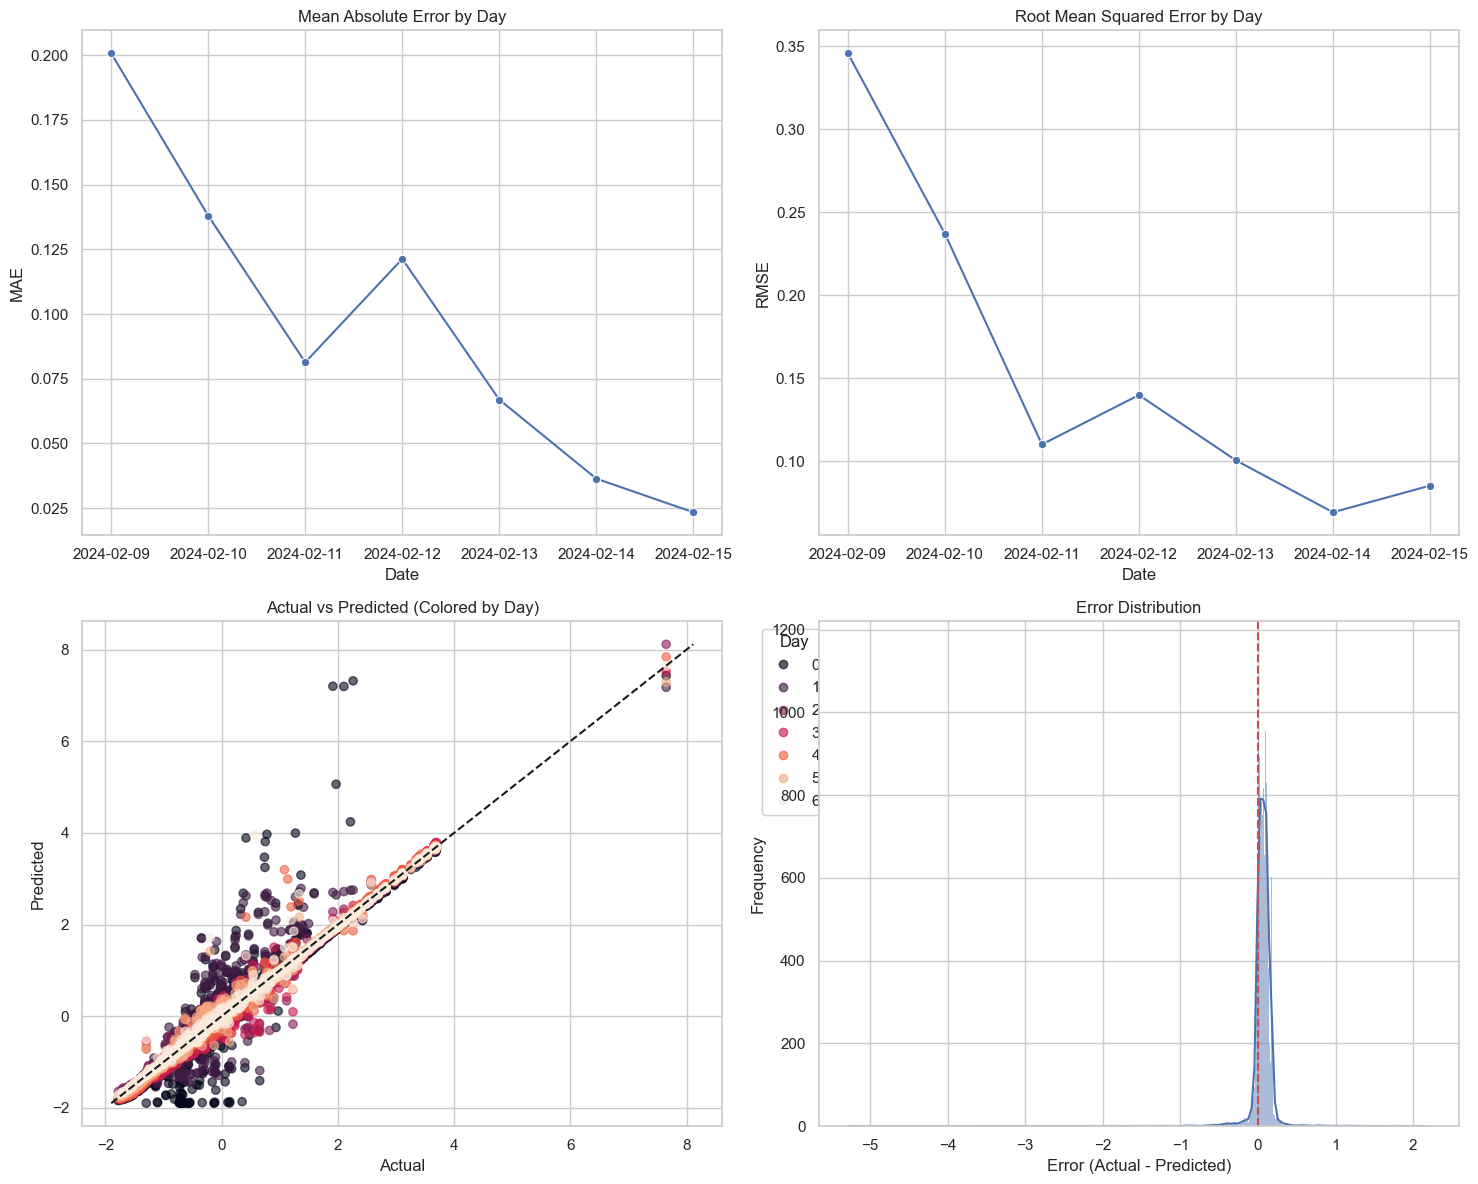

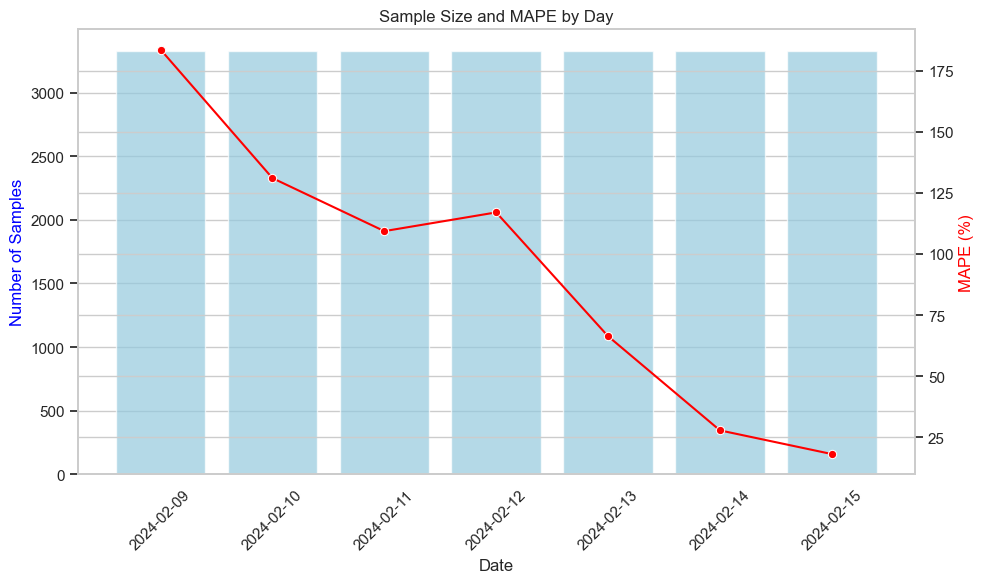

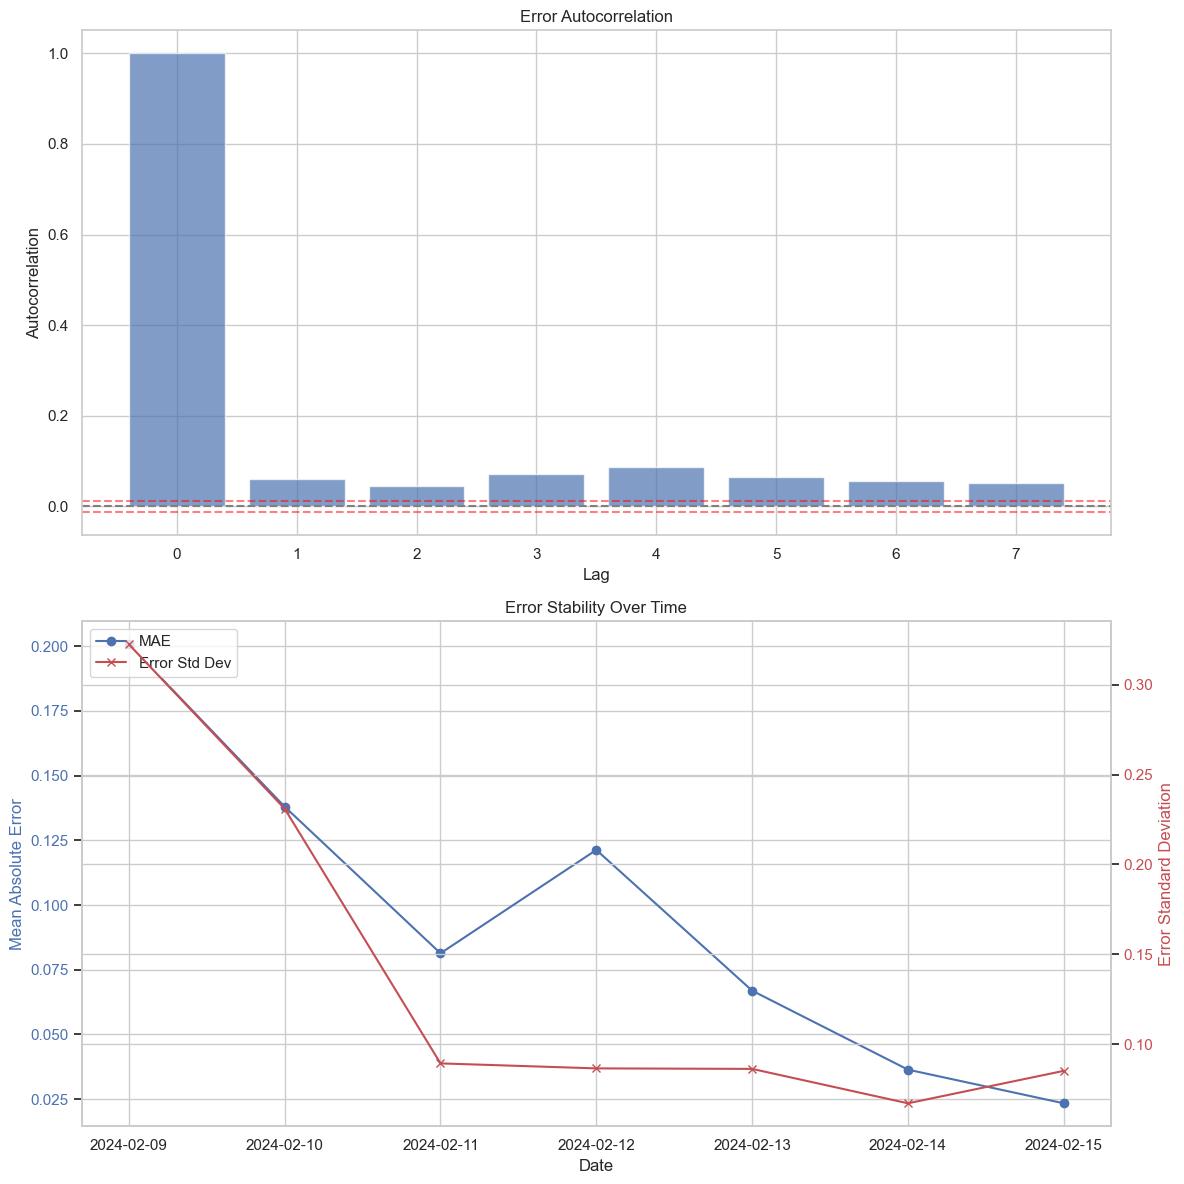

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import SAGEConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import BallTree
from math import radians
from statsmodels.tsa.stattools import acf
import numpy as np
import matplotlib.pyplot as plt


class Time2VecEncoding(nn.Module):
    """Time2Vec encoding for temporal features"""
    def __init__(self, h_dim, scale=1):
        super(Time2VecEncoding, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(1, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(1, h_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(h_dim-1))
        self.f = torch.sin
        self.scale = scale

    def forward(self, time):
        # Ensure time is 2D: [batch_size, 1]
        if len(time.shape) == 1:
            time = time.unsqueeze(-1)
        elif len(time.shape) == 3:
            # If time has shape [batch_size, seq_len, 1], take the last time step
            time = time[:, -1, :].unsqueeze(-1)
            
        # Scale time
        time = time / self.scale
        
        # Calculate linear and periodic components
        v1 = torch.matmul(time, self.w0) + self.b0  # Shape: [batch_size, 1]
        v2 = self.f(torch.matmul(time, self.w) + self.b)  # Shape: [batch_size, h_dim-1]
        
        return torch.cat([v1, v2], dim=1)  # Shape: [batch_size, h_dim]

class STRAP(nn.Module):
    """Streamlined implementation of ST-RAP model"""
    def __init__(self, input_dim, temporal_dim, hidden_dim=128, num_gru_layers=2):
        super(STRAP, self).__init__()
        
        # Feature embeddings
        self.property_embedding = nn.Linear(input_dim, hidden_dim)
        self.time_embedding = Time2VecEncoding(hidden_dim, scale=1000)
        
        # Temporal GRU layers
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_gru_layers,
            batch_first=True
        )
        self.temporal_norm = nn.LayerNorm(hidden_dim)
        
        # Spatial graph layers
        self.graph_conv = SAGEConv(hidden_dim, hidden_dim)
        self.spatial_norm = nn.LayerNorm(hidden_dim)
        
        # Final prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, edge_index=None, time_features=None):
        batch_size = x.size(0)
        
        # Property embeddings
        property_emb = self.property_embedding(x)
        
        # Process time features if provided
        if time_features is not None:
            # Take the first feature as the temporal value
            # In practice, you might want to use a more sophisticated approach
            time_val = time_features[:, 0]  # Shape: [batch_size]
            time_emb = self.time_embedding(time_val)  # Shape: [batch_size, hidden_dim]
            property_emb = property_emb + time_emb
        
        # Reshape for GRU (adding sequence dimension)
        temporal_input = property_emb.unsqueeze(1)  # Shape: [batch_size, 1, hidden_dim]
            
        # Process with GRU
        temporal_output, _ = self.gru(temporal_input)  # Shape: [batch_size, 1, hidden_dim]
        temporal_output = self.temporal_norm(temporal_output[:, -1])  # Shape: [batch_size, hidden_dim]
        
        # Process with graph convolution if edge_index provided
        if edge_index is not None and edge_index.numel() > 0:
            spatial_output = self.graph_conv(temporal_output, edge_index)
            spatial_output = self.spatial_norm(spatial_output)
        else:
            spatial_output = torch.zeros_like(temporal_output)
        
        # Combine temporal and spatial outputs
        combined = torch.cat([temporal_output, spatial_output], dim=1)
        
        # Final prediction
        output = self.predictor(combined).squeeze(-1)
        
        return output

def create_edge_index_efficient(data, k_neighbors=5, distance_threshold=2.0, chunk_size=1000):
    """
    Create spatial edge index efficiently using BallTree and chunking
    """
    print("Creating spatial edge index efficiently...")
    coords = data[['latitude', 'longitude']].values
    n_samples = len(coords)
    
    # Convert to radians for BallTree
    coords_rad = np.radians(coords)
    
    # Create BallTree
    tree = BallTree(coords_rad, metric='haversine')
    
    # Create edge index
    edge_index = []
    
    # Process in chunks to avoid memory issues
    for i in tqdm(range(0, n_samples, chunk_size)):
        end_idx = min(i + chunk_size, n_samples)
        chunk_coords = coords_rad[i:end_idx]
        
        # Query k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Convert distances from radians to km
        distances = distances * 6371.0  # Earth radius in km
        
        # Add edges for each point in chunk
        for j in range(len(chunk_coords)):
            point_idx = i + j
            for k in range(1, k_neighbors+1):  # Skip self (index 0)
                neighbor_idx = indices[j, k]
                distance = distances[j, k]
                
                if distance <= distance_threshold:
                    edge_index.append([point_idx, neighbor_idx])
                    # Add reverse edge for undirected graph
                    edge_index.append([neighbor_idx, point_idx])
    
    # Remove duplicates
    edge_index = list(set(tuple(edge) for edge in edge_index))
    edge_index = [list(edge) for edge in edge_index]
    
    return torch.tensor(edge_index, dtype=torch.long).t()

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Create spatial features similar to XGBoost implementation"""
    print("Creating spatial features...")
    city_center_lat, city_center_lon = 48.8566, 2.3522  # Paris coordinates
    
    # Calculate distance to city center and north-south position
    df['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    )
    
    df['north_south'] = df['latitude'] - city_center_lat
    
    # Create BallTree for nearest neighbor calculations
    coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(coords, metric='haversine')
    
    # Process in chunks
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    # KNN features
    knn_price_mean = np.zeros(len(df))
    knn_price_std = np.zeros(len(df))
    knn_price_median = np.zeros(len(df))
    price_diff = np.zeros(len(df))
    
    start_idx = 0
    for chunk in tqdm(chunks, desc="Processing chunks"):
        chunk_size = len(chunk)
        chunk_coords = np.radians(chunk[['latitude', 'longitude']].values)
        
        # Find k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Calculate neighbor statistics
        for i in range(chunk_size):
            # Skip self (index 0)
            neighbor_indices = indices[i, 1:]
            prices = df.iloc[neighbor_indices]['price'].values
            
            # Calculate statistics
            knn_price_mean[start_idx + i] = np.mean(prices)
            knn_price_std[start_idx + i] = np.std(prices)
            knn_price_median[start_idx + i] = np.median(prices)
            price_diff[start_idx + i] = chunk.iloc[i]['price'] - np.mean(prices)
        
        start_idx += chunk_size
    
    # Add features to dataframe
    df['knn_price_mean'] = knn_price_mean
    df['knn_price_std'] = knn_price_std
    df['knn_price_median'] = knn_price_median
    df['price_diff_from_neighbors'] = price_diff
    
    # Standardize the new features
    spatial_features = ['distance_to_center', 'north_south', 
                        'knn_price_mean', 'knn_price_std', 
                        'knn_price_median', 'price_diff_from_neighbors']
    
    for col in spatial_features:
        mean_val = df[col].mean()
        std_val = df[col].std()
        if std_val > 0:
            df[col] = (df[col] - mean_val) / std_val
    
    return df

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_strap_prediction(train_path, test_path, features_to_drop=None, prediction_days=7):
    """Run ST-RAP model with day-by-day retraining for multiple days prediction"""
    print(f"Processing dataset for {prediction_days}-day prediction")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    print(f"Features being dropped: {features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Add spatial features to enhance prediction
    train_data = create_spatial_features(train_data)
    test_data = create_spatial_features(test_data)
    
    # Create feature matrices    
    feature_cols = [col for col in train_data.columns 
                  if col not in ['listing_id', 'date', 'price']]
    
    X_train = train_data[feature_cols].values
    y_train = train_data['price'].values
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = STRAP(
        input_dim=len(feature_cols),
        temporal_dim=5,  # Temporal features: day, month, weekend, season_sin, season_cos
        hidden_dim=128
    ).to(device)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Define loss function
    criterion = nn.MSELoss()
    
    # Initialize results storage
    daily_results = []
    
    # We won't use graph structure to avoid computational overhead
    # Set edge_index to None
    edge_index = None
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        X_test_day = day_test[feature_cols].values
        y_test_day = day_test['price'].values
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)
        X_test_tensor = torch.FloatTensor(X_test_day).to(device)
        y_test_tensor = torch.FloatTensor(y_test_day).to(device)
        
        # Extract time features
        time_cols = ['DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos']
        if all(col in train_data.columns for col in time_cols):
            time_features_train = torch.FloatTensor(train_data[time_cols].values).to(device)
            time_features_test = torch.FloatTensor(day_test[time_cols].values).to(device)
        else:
            # If time columns don't exist, create dummy time features
            print("Warning: Time columns not found. Using dummy time features.")
            time_features_train = torch.zeros((len(X_train_tensor), 5), device=device)
            time_features_test = torch.zeros((len(X_test_tensor), 5), device=device)
        
        # Create DataLoader for training
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, time_features_train, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Train model
        model.train()
        epochs = 3  # Reduced epochs for faster training
        
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            for batch_x, batch_time, batch_y in train_loader:
                # Forward pass - pass None for edge_index
                outputs = model(batch_x, None, batch_time)
                
                # Calculate loss
                loss = criterion(outputs, batch_y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
            
            # Print epoch stats
            avg_loss = total_loss/batch_count if batch_count > 0 else 0
            print(f"Day: {day}, Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor, None, time_features_test)
            test_loss = criterion(y_pred, y_test_tensor).item()
        
        # Convert predictions to numpy
        y_pred_np = y_pred.cpu().numpy()
        
        # Store results for the day
        day_results = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'actual': y_test_day,
            'predicted': y_pred_np,
            'abs_error': np.abs(y_test_day - y_pred_np),
            'pct_error': np.abs((y_test_day - y_pred_np) / y_test_day) * 100
        })
        
        daily_results.append(day_results)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day
        X_train = np.concatenate([X_train, X_test_day])
        y_train = np.concatenate([y_train, y_test_day])
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['actual'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['actual'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    # Calculate error autocorrelation
    all_results['error'] = all_results['actual'] - all_results['predicted']
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability

    return evaluation_results

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['actual'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['actual'].min(), all_results['predicted'].min())
    max_val = max(all_results['actual'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['actual'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== ST-RAP MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")


if __name__ == "__main__":
    import os
    
    # Specify paths to your data
    train_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_expensive_listings_subset\train.csv"
    test_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_expensive_listings_subset\test_feb.csv"
    
    # Run prediction for 7 days
    results = run_day_by_day_strap_prediction(
        train_path=train_path,
        test_path=test_path,
        prediction_days=7
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_results(results)

    # Add new error analysis plots
    plot_error_analysis(results)